In [244]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import missingno as msno
import plotly.express as px
from math import sqrt
from statistics import mean
import feature_engineering

In [245]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:
data_path = './data/'
df_x = pd.read_csv(data_path+'X_train.csv')
df_y = pd.read_csv(data_path+'Y_train.csv')

Empty values

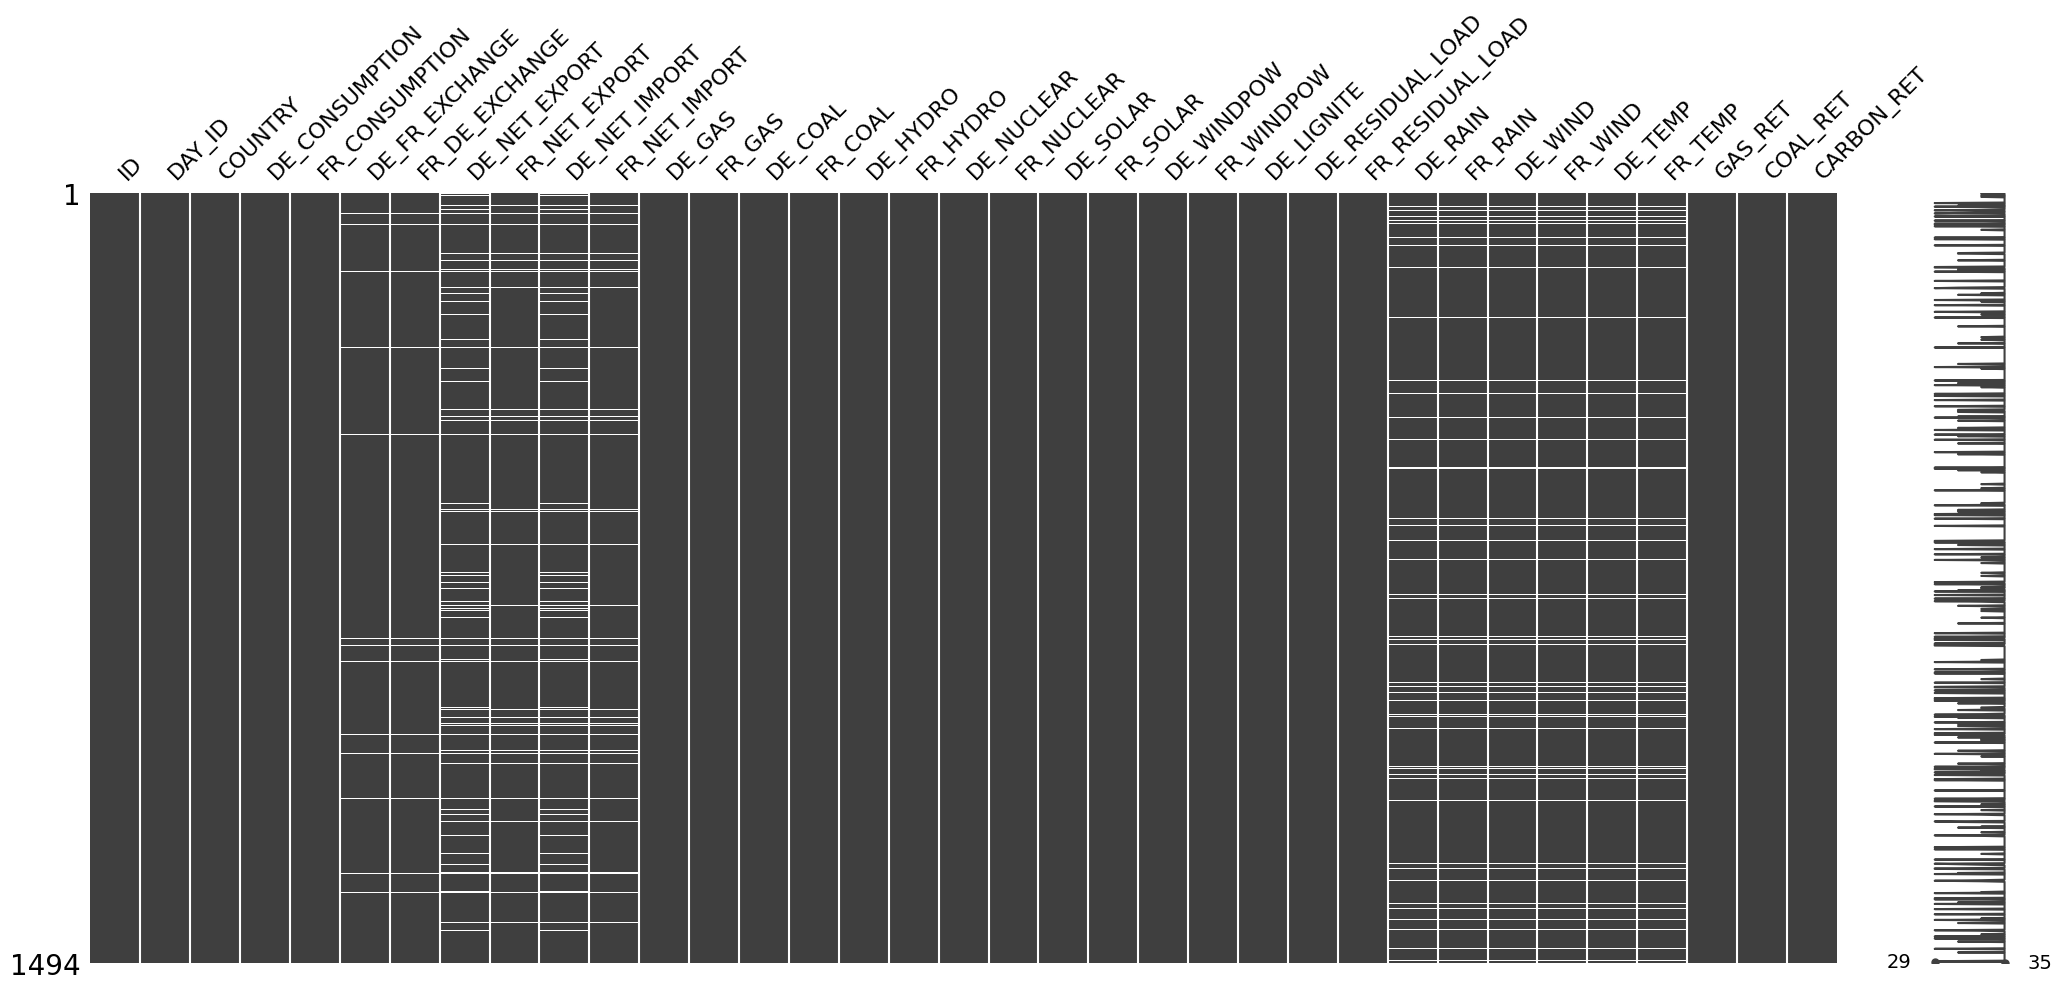

In [246]:
_ = msno.matrix(df_x)

In [247]:
print(f"Nan of FR_RAIN: count -> {df_x['FR_RAIN'].isna().sum()}, ratio -> {round(100*df_x['FR_RAIN'].isna().sum()/len(df_x), 2)} %")
print(f"Nan of DE_NET_IMPORT: count -> {df_x['DE_NET_IMPORT'].isna().sum()}, ratio -> {round(100*df_x['DE_NET_IMPORT'].isna().sum()/len(df_x), 2)} %")

Nan of FR_RAIN: count -> 94, ratio -> 6.29 %
Nan of DE_NET_IMPORT: count -> 124, ratio -> 8.3 %


In [248]:
print(f"number of 0 in FR_RAIN col: {df_x.loc[df_x['FR_RAIN'] == 0].shape[0]}")
print(f"number of 0 in FR_RAIN col: {df_x.loc[df_x['DE_TEMP'] == 0].shape[0]}")
print(f"number of 0 in DE_NET_IMPORT col: {df_x.loc[df_x['DE_NET_IMPORT'] == 0].shape[0]}")

number of 0 in FR_RAIN col: 0
number of 0 in FR_RAIN col: 0
number of 0 in DE_NET_IMPORT col: 0


Filling missing values with other values 0

In [249]:
print(df_x['COUNTRY'].value_counts())
df_x = df_x.drop(['COUNTRY'], axis=1).fillna(0)

COUNTRY
FR    851
DE    643
Name: count, dtype: int64


Constant features?

In [250]:
non_constants_features = feature_engineering.low_var_features(df_x, threshold=0)
print(f"number of features : {df_x.shape[1]}")
print(f"number of constant features : {df_x.shape[1] - len(non_constants_features)}")

number of features : 34
number of constant features : 0


Correlated features?

In [251]:
most_correlated_features = feature_engineering.get_most_correlated(df_x)
most_correlated_features

DE_NET_EXPORT   DE_NET_IMPORT      -1.000
FR_NET_EXPORT   FR_NET_IMPORT      -1.000
DE_FR_EXCHANGE  FR_DE_EXCHANGE     -1.000
FR_CONSUMPTION  FR_RESIDUAL_LOAD    0.965
DE_WIND         FR_WIND             0.821
                                    ...  
DAY_ID          DE_COAL            -0.001
DE_COAL         COAL_RET            0.001
DE_SOLAR        CARBON_RET          0.001
ID              FR_RAIN            -0.001
                COAL_RET           -0.000
Length: 561, dtype: float64

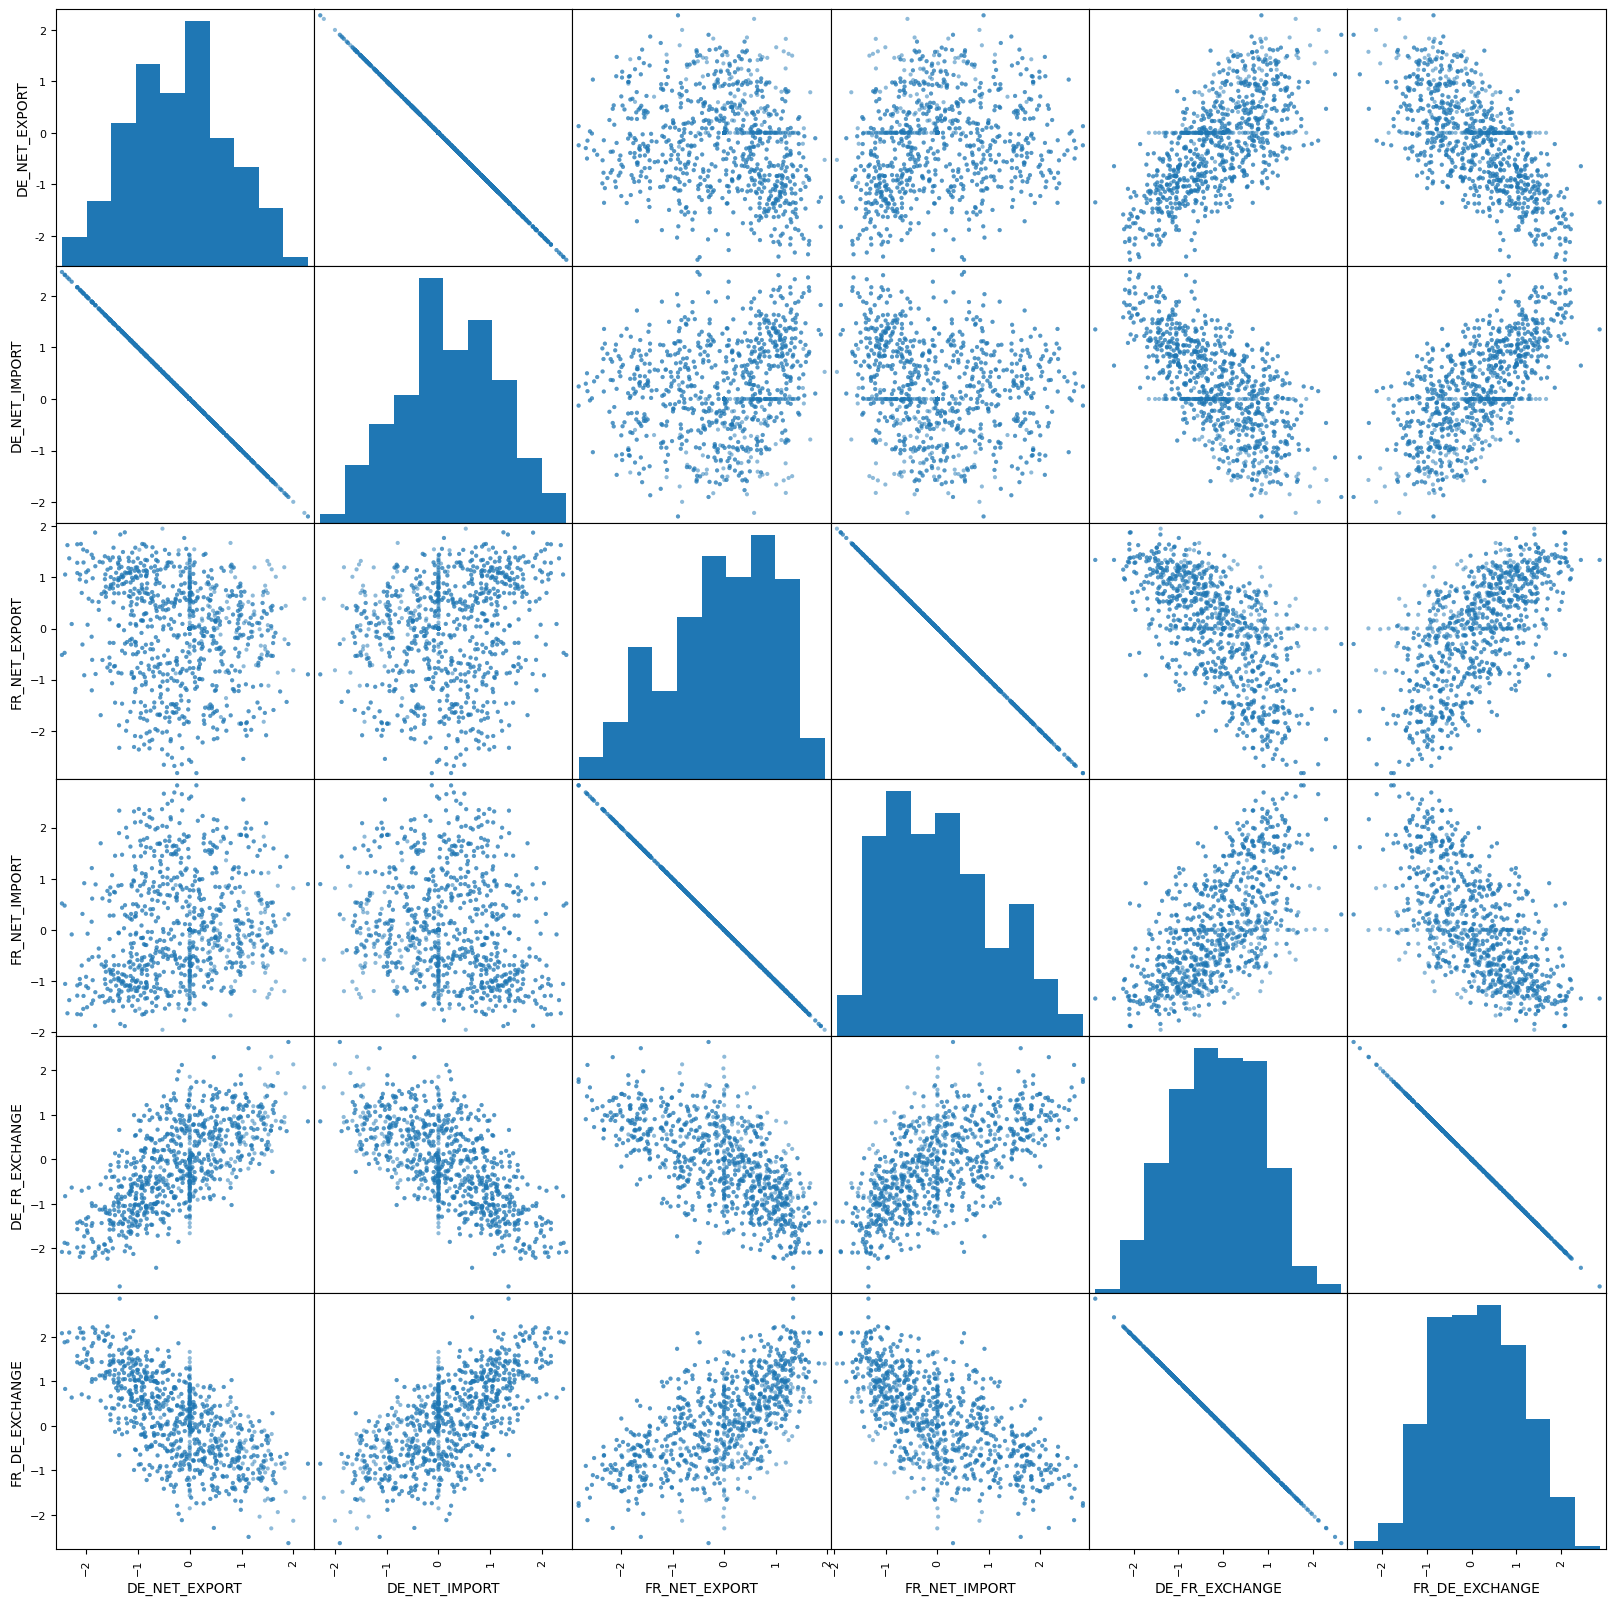

In [252]:
# pd.plotting.scatter_matrix(x_train[['DE_NET_EXPORT', 'DE_NET_IMPORT']], figsize=(20, 20))
_ = pd.plotting.scatter_matrix(df_x[['DE_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_EXPORT', 'FR_NET_IMPORT', 'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE']], figsize=(20, 20))

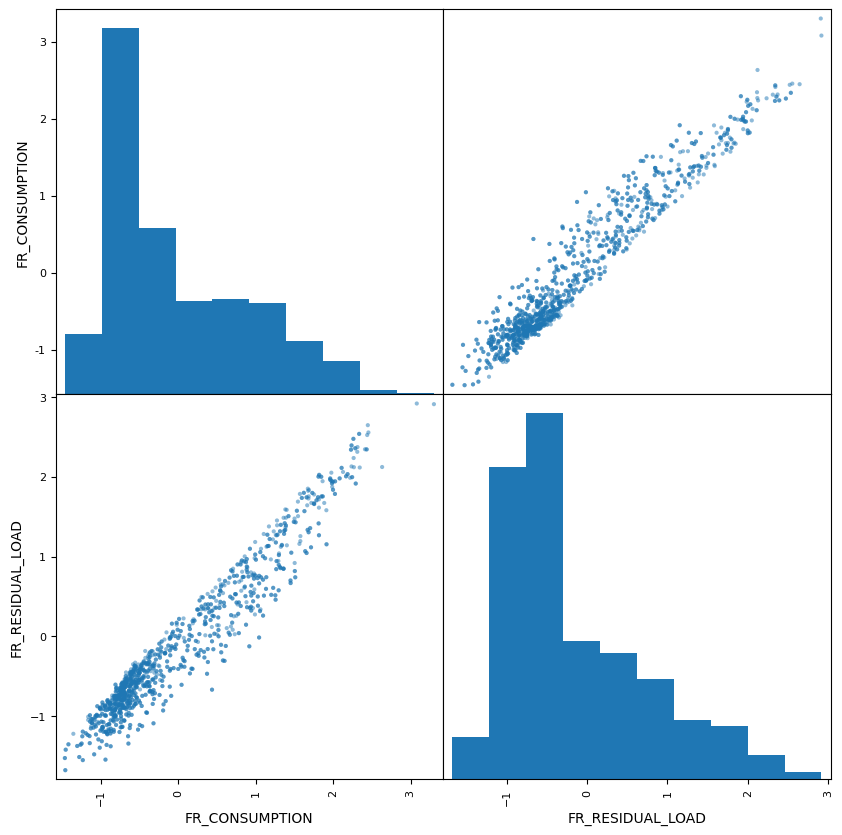

In [253]:
_ = pd.plotting.scatter_matrix(df_x[['FR_CONSUMPTION', 'FR_RESIDUAL_LOAD']], figsize=(10, 10))

In [254]:
# _ = pd.plotting.scatter_matrix(df_x.drop(columns=['ID', 'DAY_ID']), figsize=(20, 20))

In [255]:
features_to_remove = ['DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_FR_EXCHANGE']
if('DE_NET_EXPORT' in df_x):
    df_x.drop(columns=features_to_remove, inplace=True)
len(df_x.columns)

31

Splitting

In [270]:
x_train = df_x[:round(0.8*len(df_x))].set_index(['ID', 'DAY_ID'])
y_train = df_y[:round(0.8*len(df_x))].set_index(['ID'])
x_test = df_x[round(0.8*len(df_x)):].set_index(['ID', 'DAY_ID'])
y_test = df_y[round(0.8*len(df_x)):].set_index(['ID'])

def metric_train(output):
    return  spearmanr(output, y_test['TARGET']).correlation

print(f"length of train set: {len(x_train)}, length of test set: {len(x_test)}")

length of train set: 1195, length of test set: 299


Checking feature importance

In [272]:
linear_regr_scaled = make_pipeline(StandardScaler(), LinearRegression())

linear_regr_scaled.fit(x_train, y_train['TARGET'])
# linear_regr_scaled[1].coef_
df_features_importances = pd.DataFrame(data={'features': x_test.columns, 'coeff': [abs(i) for i in linear_regr_scaled[1].coef_]}).sort_values(by=['coeff'], ascending=False)
print(df_features_importances)
results = linear_regr_scaled.predict(x_test)
metric_train(results)

            features     coeff
19  FR_RESIDUAL_LOAD  0.570544
1     FR_CONSUMPTION  0.423789
16        FR_WINDPOW  0.251758
3      DE_NET_IMPORT  0.229186
12        FR_NUCLEAR  0.204601
18  DE_RESIDUAL_LOAD  0.204361
2     FR_DE_EXCHANGE  0.176168
14          FR_SOLAR  0.133025
4      FR_NET_IMPORT  0.120223
0     DE_CONSUMPTION  0.096878
5             DE_GAS  0.088120
17        DE_LIGNITE  0.080122
15        DE_WINDPOW  0.078822
23           FR_WIND  0.074707
10          FR_HYDRO  0.069751
6             FR_GAS  0.053917
9           DE_HYDRO  0.051285
24           DE_TEMP  0.040835
8            FR_COAL  0.031952
22           DE_WIND  0.026164
7            DE_COAL  0.018864
21           FR_RAIN  0.016845
20           DE_RAIN  0.014078
26           GAS_RET  0.013893
11        DE_NUCLEAR  0.008099
13          DE_SOLAR  0.008019
28        CARBON_RET  0.004902
25           FR_TEMP  0.000851
27          COAL_RET  0.000606


np.float64(0.1436304000768826)

In [281]:
df_features_importances.loc[df_features_importances['coeff'] == df_features_importances['coeff'].min(), 'features'].values[0]

'COAL_RET'

In [296]:
features_selection = x_train.columns
features_removed = []
scores_values = pd.DataFrame(columns=['removed_feat_count', 'score'])
for i in range(len(x_train.columns)-1):
    print(f"features removed: {features_removed}")
    linear_regr_scaled = make_pipeline(StandardScaler(), LinearRegression())

    linear_regr_scaled.fit(x_train[features_selection], y_train['TARGET'])
    # linear_regr_scaled[1].coef_
    results = linear_regr_scaled.predict(x_test[features_selection])
    score = metric_train(results)
    print(f"RESULT : {score}\n\n")
    scores_values.loc[len(scores_values)] = [len(features_removed), score]
    df_features_importances = pd.DataFrame(data={'features': x_test[features_selection].columns, 'coeff': [abs(i) for i in linear_regr_scaled[1].coef_]}).sort_values(by=['coeff'], ascending=False)
    print(df_features_importances.tail(5))
    features_removed.append(df_features_importances.loc[df_features_importances['coeff'] == df_features_importances['coeff'].min(), 'features'].values[0])
    features_selection = [i for i in features_selection if i not in features_removed]
scores_values

features removed: []
RESULT : 0.1436304000768826


      features     coeff
11  DE_NUCLEAR  0.008099
13    DE_SOLAR  0.008019
28  CARBON_RET  0.004902
25     FR_TEMP  0.000851
27    COAL_RET  0.000606
features removed: ['COAL_RET']
RESULT : 0.14379470661407248


      features     coeff
26     GAS_RET  0.013813
11  DE_NUCLEAR  0.008080
13    DE_SOLAR  0.008032
27  CARBON_RET  0.004726
25     FR_TEMP  0.000852
features removed: ['COAL_RET', 'FR_TEMP']
RESULT : 0.1438898787066524


      features     coeff
20     DE_RAIN  0.013992
25     GAS_RET  0.013790
13    DE_SOLAR  0.008146
11  DE_NUCLEAR  0.008081
26  CARBON_RET  0.004762
features removed: ['COAL_RET', 'FR_TEMP', 'CARBON_RET']
RESULT : 0.14285510666232823


      features     coeff
21     FR_RAIN  0.016833
25     GAS_RET  0.015812
20     DE_RAIN  0.013611
11  DE_NUCLEAR  0.008563
13    DE_SOLAR  0.008135
features removed: ['COAL_RET', 'FR_TEMP', 'CARBON_RET', 'DE_SOLAR']
RESULT : 0.14202504440204386


      features     coeff
7   

,removed_feat_count,score
0,0.0,0.143630
1,1.0,0.143795
2,2.0,0.143890
3,3.0,0.142855
4,4.0,0.142025
5,5.0,0.144226
6,6.0,0.144738
7,7.0,0.146780
8,8.0,0.139173
9,9.0,0.141577


In [297]:
figure = px.line(scores_values, 'removed_feat_count', 'score')
figure.show()

Check Spearman correlation

In [ ]:
output_train = lr.predict(X_train_clean)

def metric_train(output):
    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))